In [25]:
## Readme

# This is an implementation of Liu et al. (2018)
# - https://www.sciencedirect.com/science/article/abs/pii/S0022509618303223

# , but solving for matrix viscoelasticity using the method of Reese and Govindjee. 
# - https://www.sciencedirect.com/science/article/abs/pii/S0020768397002175

# In the case of fibers viscoelasticity, i used a linear ODE as in:
# - https://www.sciencedirect.com/science/article/pii/S0020768307002582 
# or
# - https://www.sciencedirect.com/science/article/abs/pii/S0045782506003045

# The difference with the results of the paper is mainly in the fiber response.

In [26]:
## Packages
from dolfinx.mesh import (create_box, CellType,
                          locate_entities_boundary, meshtags)
from dolfinx.fem import (FunctionSpace, TensorFunctionSpace,
                         VectorFunctionSpace, Function, dirichletbc,
                         locate_dofs_topological, Constant)
from ufl import (FiniteElement, VectorElement, TensorElement,
                 MixedElement, TestFunction, TrialFunction,
                 split, SpatialCoordinate, Measure,
                 Identity, grad, det, inv, tr, exp, ln, inner,
                 dot, as_tensor, as_vector, derivative,
                 sin, cos, outer, variable, transpose, shape,
                 sym, sqrt)

from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py.PETSc import ScalarType 
from dolfinx.geometry import (BoundingBoxTree,
                              compute_colliding_cells, 
                              compute_collisions)
from mpi4py import MPI

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tqdm.autonotebook

In [27]:
## Useful functions

def project(v, target_func, bcs=[]):
    '''
    This function is from dolfiny package
    '''
    from ufl import (dx, TestFunction, TrialFunction, inner)
    from dolfinx.fem import (form, assemble)
    from dolfinx.fem.petsc import (assemble_matrix, assemble_vector, apply_lifting,
                                   set_bc)
    from petsc4py import PETSc
    
    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    
    metadata = {"quadrature_degree": 2} 
    
    dx = dx(V.mesh, metadata=metadata)

    # Define variational problem for projection
    w  = TestFunction(V)
    Pv = TrialFunction(V)
    a  = form(inner(Pv, w) * dx)
    L  = form(inner(v, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_func.vector)
    
def plot_mesh(mesh):
    '''
    To plot mesh
    '''
    
    from dolfinx.plot import create_vtk_mesh
    
    try:
        import pyvista
    except ModuleNotFoundError:
        print("pyvista is required for this demo")
        exit(0)

    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        
    # Extract mesh data from dolfin-X (only plot cells owned by the
    # processor) and create a pyvista UnstructuredGrid
    num_cells = mesh.topology.index_map(mesh.topology.dim).size_local
    cell_entities = np.arange(num_cells, dtype=np.int32)
    pyvista_cells = create_vtk_mesh(
        mesh, mesh.topology.dim, cell_entities)
    grid = pyvista.UnstructuredGrid(pyvista_cells[0],pyvista_cells[1], mesh.geometry.x)

    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, style="wireframe", line_width=2, color="black")
    #plotter.view_xy()
    # Save as png if we are using a container with no rendering
    if pyvista.OFF_SCREEN:
        plotter.screenshot("tmp.png")
    else:
        plotter.show()    
    ## -----------------------------------------------        
        
def EVAL(mesh,FUNCT,point):
    '''
    To evaluate a function at a point
    
    FUNCT : Function
    point : point in the body
    '''
    
    # select a point in the mesh in the border between the two processes
    if len(point) == 2:
        rand_global_point = [point[0], point[1], 0.] 
    elif len(point) == 3:
        rand_global_point = [point[0], point[1], point[2]] 

        
    # get bbt for the mesh
    mesh_bbt = BoundingBoxTree(mesh, mesh.topology.dim)

    # convert point in array with one element
    points_list_array = np.array([rand_global_point])
    # for each point, compute a colliding cells and append to the lists
    points_on_proc = []
    cells = []
    cell_candidates = compute_collisions(mesh_bbt, points_list_array)  # get candidates
    colliding_cells = compute_colliding_cells(mesh, cell_candidates, points_list_array)  # get actual
    for i, point in enumerate(points_list_array):
        if len(colliding_cells.links(i)) > 0:
            cc = colliding_cells.links(i)[0]
            points_on_proc.append(point)
            cells.append(cc)
    # convert to numpy array
    points_on_proc = np.array(points_on_proc)
    cells = np.array(cells)
    
    return FUNCT.eval(points_on_proc, cells)
    ## -----------------------------------------------

def assign(mesh, A, FUNCT):
    '''
    To assign values from a tuple
    
    FUNCT: Function
    A    : must be a tuple. For example:
    
    scalar "2.0"                    values =   2.0 
    vector "(1.0,2.0)"              values =  (1.0,2.0)       
    tensor "[(1.0,2.0),(3.0,4.0)]"  values =  (1.0,...,4.0)     
    '''
 
    values_ = Constant(mesh, ScalarType(A))  
    
    return project(values_, FUNCT)
    ## -----------------------------------------------

def Value(mesh,A,point):
    '''
    To convert "fenicsx values" to "normal values"
    
    A    : scalar, vector, or tensor (ufl)
    point: coordinates at which the field is calculated (tuple)
    '''
    from dolfinx.fem import (FunctionSpace, TensorFunctionSpace,
                              VectorFunctionSpace, Function)
    from ufl import (FiniteElement, shape)
    

    if shape(A) == (2,) or shape(A) == (3,):
        fspace    = VectorFunctionSpace(mesh, ("CG",1))
        B         = Function(fspace)
        project(A, B) # A -> B (Coeficcient)
        return EVAL(mesh,B,point)
        
    elif shape(A) == (2,2) or shape(A) == (3,3):
        fspace    = TensorFunctionSpace(mesh, ("DG",0))
        B         = Function(fspace)
        project(A, B) # A -> B (Coeficcient)
        dim = shape(B)[0]
        return np.reshape(EVAL(mesh,B,point),[dim,dim])
    else:
        element   = FiniteElement("CG", mesh.ufl_cell(), 1)
        fspace    = FunctionSpace(mesh, element) 
        B         = Function(fspace)
        # when A is not coefficient
        if type(A) != type(B):
            project(A, B) # A -> B (Coeficcient)
            return EVAL(mesh,B,point)[0]
        # when A is already a Coefficient class:
        else: 
            return EVAL(mesh,A,point)[0]
    ## -----------------------------------------------
    
def eigenValues(T, tol=1e-9):
    dim=T.geometric_dimension()                                                 # get geometric dimension of tensor T to decide which subroutine to use for eigenvalue computations

    # choose projection tensor routine based on dimensionality of problem
    if dim == 2:                                                                # 2D-problem
        return _eigVal2D(T,tol)
    else:                                                                       # 3D-problem
        return _eigVal3D(T,tol)

def _eigVal3D(T, tol):                                                           # dolfin module
    from ufl import (tr, inner, det, conditional, sign, lt,
                     atan_2, sqrt, cos, sin)                                                                      # ufl module
    import numpy as np                                                              # numpy
    import copy as cp 

    # determine perturbation from tolerance
    pert = 2*tol

    # get required invariants
    I1 = tr(T)                                                               # trace of tensor
    I2 = 0.5*(tr(T)**2-inner(T,T))                                        # 2nd invariant of tensor
    I3 = det(T)                                                              # determinant of tensor

    p = I1**2 - 3*I2                                                            # preliminary value for p
    p = conditional(lt(p,tol),abs(p)+pert,p)                            # add numerical perturbation to p, if close to zero; ensure positiveness of p
    q = 27/2*I3 + I1**3 - 9/2*I1*I2                                             # preliminary value for q
    q = conditional(lt(abs(q),tol),q+sign(q)*pert,q)                # add numerical perturbation (with sign) to value of q, if close to zero

    # determine angle phi for calculation of roots
    phiNom2 =  27*( 1/4*I2**2*(p-I2) + I3*(27/4*I3-q) )                         # preliminary value for squared nominator of expression for angle phi
    phiNom2 = conditional(lt(phiNom2,tol),abs(phiNom2)+pert,phiNom2)    # add numerical perturbation to ensure non-zero nominator expression for angle phi
    phi = 1/3*atan_2(sqrt(phiNom2),q)                                   # calculate angle phi

    # calculate polynomial roots
    lambda1 = 1/3*(sqrt(p)*2*cos(phi)+I1)
    lambda2 = 1/3*(-sqrt(p)*(cos(phi)+sqrt(3)*sin(phi))+I1)
    lambda3 = 1/3*(-sqrt(p)*(cos(phi)-sqrt(3)*sin(phi))+I1)

    # return polynomial roots (eigenvalues)
    return lambda1, lambda2, lambda3

def projectionTensors(T, *eigenValues):
    dim=T.geometric_dimension()                                                 # get geometric dimension of tensor T to decide which subroutine to use for projection tensor computations

    # choose projection tensor routine based on dimensionality of problem
    if dim == 2:                                                                # 2D-problem
        return _projTen2D(T,*eigenValues)
    else:                                                                       # 3D-problem
        return _projTen3D(T,*eigenValues)

def _projTen3D(T, lambda1, lambda2, lambda3):
    import ufl                                                                      # ufl module

    # get required quantities
    I = ufl.Identity(3)

    # calculate the individual projection tensors
    M1 = (T-lambda2*I)*(T-lambda3*I)/((lambda1-lambda2)*(lambda1-lambda3))
    M2 = (T-lambda3*I)*(T-lambda1*I)/((lambda2-lambda3)*(lambda2-lambda1))
    M3 = (T-lambda1*I)*(T-lambda2*I)/((lambda3-lambda1)*(lambda3-lambda2))

    # return projection tensors
    return M1, M2, M3

In [28]:
## Mesh
comm = MPI.COMM_WORLD

dimx, dimy , dimz = 1, 0.5, 1
nx, ny, nz = 1, 1, 1

mesh = create_box(comm,[[0.,0.,0.],[dimx,dimy,dimz]],[nx,ny,nz],CellType.hexahedron)

gdim = mesh.geometry.dim # geometry dimension
tdim = mesh.topology.dim # topology dimension
fdim = tdim - 1          # facet dimension


In [29]:
## Facets identification

left   = lambda x: np.isclose(x[0], 0)
right  = lambda x: np.isclose(x[0], dimx)
bottom = lambda x: np.isclose(x[1], 0)
top    = lambda x: np.isclose(x[1], dimy)
back   = lambda x: np.isclose(x[2], 0)
front  = lambda x: np.isclose(x[2], dimz)

left_facets   = locate_entities_boundary(mesh, fdim, left)
right_facets  = locate_entities_boundary(mesh, fdim, right)
bottom_facets = locate_entities_boundary(mesh, fdim, bottom)
top_facets    = locate_entities_boundary(mesh, fdim, top)
back_facets   = locate_entities_boundary(mesh, fdim, back)
front_facets  = locate_entities_boundary(mesh, fdim, front)


marked_facets = np.hstack([left_facets, right_facets,
                           bottom_facets, top_facets,
                           back_facets, front_facets])

marked_values = np.hstack([np.full_like(left_facets,   1),
                           np.full_like(right_facets,  2),
                           np.full_like(bottom_facets, 3),
                           np.full_like(top_facets,    4),
                           np.full_like(back_facets,   5),
                           np.full_like(front_facets,  6)])

sorted_facets = np.argsort(marked_facets)
facet_tag = meshtags(mesh, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

In [30]:
## Integration
metadata = {"quadrature_degree": 2}
ds = Measure('ds', domain=mesh, subdomain_data=facet_tag, metadata=metadata)
dx = Measure("dx", domain=mesh, metadata=metadata)

In [31]:
## Approximation space
W     = VectorFunctionSpace(mesh, ("CG",1))
u     = Function(W) 
u_    = TestFunction(W)
du    = TrialFunction(W)  

u_old = Function(W)

# Scalar space
fe    = FiniteElement("CG", mesh.ufl_cell(), 1)   
ET0   = FunctionSpace(mesh, fe)   
# Vector space
ET1   = VectorFunctionSpace(mesh, ("CG", 1))
# Tensor space
ET2   = TensorFunctionSpace(mesh, ("DG",0))

In [32]:
## Material parameters
tau1, tau2   = 1.0   , 1.0
beta1, beta2 = 1.0   , 1.0  #0.000001
k, c         = 1e6   , 0.877   #[kPa,kPa] 
k1, k2       = 0.154 , 34.157  #[kPa,-] 
tau1, tau2   = 1.0    , 1.0
etaM         = 1.5
etaF         = 1.5

dt = 0.1 # [s]

In [33]:
## Fibers configuration
theta  = np.radians(0.0)
a0     = as_vector([cos(theta),sin(theta),0]) 
A0     = outer(a0,a0)                       

In [34]:
## Internal variables
bMe      = Function(ET2) # bᵐₑ
invCMv   = Function(ET2) # (Cᵐᵥ)⁻¹ 
lamFv    = Function(ET0) # λᶠᵥ

I4e_  = Function(ET0) # Ī₄ₑ
Ie_   = Function(ET0) # Īₑ

In [35]:
## Initial Values

I0 = ((1.0,0.0,0.0),(0.0,1.0,0.0),(0.0,0.0,1.0))

# Displacement
assign(mesh,(0.,0.,0.),u) 

## Matrix viscoelasticity internal variable
# [bᵐₑ]₀  = I
assign(mesh, I0, bMe)
# Stretches
lamM1e = 1.0 # [λᵐ₁ₑ]₀ = 1
lamM2e = 1.0 # [λᵐ₂ₑ]₀ = 1
lamM3e = 1.0 # [λᵐ₃ₑ]₀ = 1
eps1e  = 0.0
eps2e  = 0.0
eps3e  = 0.0
# [(Cᵐᵥ)⁻¹]₀  = I
assign(mesh,I0,invCMv)
# [Īₑ]ⁿ⁺¹  = 3    
assign(mesh,3.0,Ie_)  

## Fibers viscoelasticity internal variable
# [λᶠᵥ]₀   = 1 
assign(mesh,1.0,lamFv)      
# [Ī₄ₑ]ⁿ⁺¹ = 1
assign(mesh,1.0,I4e_)    

In [36]:
def MatrixEvolution(F,invCMv,eps0):
    """
    eps0  = ln[λᵐ₁ₑ]ₙ₋₁  (initial guest)
    invCMv = [Cᵐᵥ]ₙ₋₁    
    """
    ## Kinematics
    J   = det(F)

    #print("Solving Matrix viscoelasticity...")
    
    ## Elastic predictor
    bMe_trial    = F*invCMv*F.T # [(bᵐₑ)ₜᵣᵢₐₗ]ₙ = [F]ₙ[Cᵐᵥ⁻¹]ₙ₋₁[F]ₙᵀ
    
    lamMe2_trial1, lamMe2_trial2,  lamMe2_trial3  = eigenValues(bMe_trial)
    lamMe_trial1 , lamMe_trial2 ,  lamMe_trial3   = sqrt(lamMe2_trial1), sqrt(lamMe2_trial2),  sqrt(lamMe2_trial3)

    
    ## Python values (these are scalars so the point to be evaluated is irrelevant)
    
    JJ       = Value(mesh,J,(0,0,0))
    l1trial  = Value(mesh,ln(lamMe_trial1),(0,0,0))
    l2trial  = Value(mesh,ln(lamMe_trial2),(0,0,0))
    l3trial  = Value(mesh,ln(lamMe_trial3),(0,0,0))
    epsTrial = [l1trial, l2trial, l3trial]

    #print("eps trial:",epsTrial)

    ## Inelastic corrector

    mu    = 2.*c
    alpha = 2. # Neo-Hookean

    def rA(eps):
        r1 = eps[0] + mu*dt*1/(2*etaM)*( 2/3*JJ**(-2/3)*np.exp(2.*eps[0]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[1]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[2]) ) - epsTrial[0]
        r2 = eps[1] + mu*dt*1/(2*etaM)*( 2/3*JJ**(-2/3)*np.exp(2.*eps[1]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[0]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[2]) ) - epsTrial[1]
        r3 = eps[2] + mu*dt*1/(2*etaM)*( 2/3*JJ**(-2/3)*np.exp(2.*eps[2]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[0]) - 1/3*JJ**(-2/3)*np.exp(2.*eps[1]) ) - epsTrial[2]
        r  = [r1,
              r2,
              r3] 
        return r # 3x1

    def Kab(eps):
        dr1d1 = 1. + dt*1/(2*etaM)*(mu*alpha)*( 4/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[1]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[2]) )
        dr1d2 = 1. + dt*1/(2*etaM)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[0]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[1]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[2]) )
        dr1d3 = 1. + dt*1/(2*etaM)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[0]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[2]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[1]) )

        dr2d1 = 1. + dt*1/(2*etaM)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[1]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[2]) )
        dr2d2 = 1. + dt*1/(2*etaM)*(mu*alpha)*( 4/9*JJ**(-2/3)*np.exp(2.*eps[1]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[2]) )
        dr2d3 = 1. + dt*1/(2*etaM)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[1]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[2]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[0]) )  

        dr3d1 = 1. + dt*1/(2*etaM)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[2]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[1]) )
        dr3d2 = 1. + dt*1/(2*etaM)*(mu*alpha)*(-2/9*JJ**(-2/3)*np.exp(2.*eps[2]) - 2/9*JJ**(-2/3)*np.exp(2.*eps[1]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[0]) )
        dr3d3 = 1. + dt*1/(2*etaM)*(mu*alpha)*( 4/9*JJ**(-2/3)*np.exp(2.*eps[2]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[0]) + 1/9*JJ**(-2/3)*np.exp(2.*eps[1]) )

        Jab = [[dr1d1,dr1d2,dr1d3],
               [dr2d1,dr2d2,dr2d3],
               [dr3d1,dr3d2,dr3d3]]
               
        return Jab # 3x3

    # Initial guest, from the previous iteration
    EPSk0 = [eps0[0],eps0[1],eps0[2]]
    
    # print('Initial eps:\n',EPSk0)

    from scipy.optimize import fsolve
    EPSk = fsolve(rA, EPSk0, fprime=Kab)
    
    # print('Predicted eps:\n',EPSk)
    # print('Residual: \n',rA(EPSk))
    
    ## FEniCS
    eps    = [EPSk[0]          , EPSk[1]          , EPSk[2]          ]   # [ε₁ₑ]ₙ      , [ε₂ₑ]ₙ   , [ε₂₃]ₙ 
    lamMe  = [np.exp(eps[0])   , np.exp(eps[1])   , np.exp(eps[2])   ]   # [λᵐ₁ₑ]ₙ     , [λᵐ₂ₑ]ₙ     principal stretches

    ## Eigen-basis nᵢ⊗nᵢ
    n1xn1, n2xn2, n3xn3  = projectionTensors(bMe_trial, lamMe2_trial1, lamMe2_trial2, lamMe2_trial3) 
    nxn = [n1xn1, n2xn2, n3xn3]

    # print('Internal variable updated')

    return lamMe, nxn, eps

In [37]:
def FiberEvolution(F,lamFv0):
    from scipy import optimize
    
    #### Kinematics
    J   = det(F)
    F_  = J**(-1/3)*F
    C_  = F_.T*F_
    I4_ = inner(C_,A0)

    ## Python values
    I4iso     = Value(mesh,I4_,(0,0,0))
    stretchF0 = Value(mesh,lamFv0,(0,0,0))
       

    def tauFneq(stretchF):
        I4eiso = I4iso/(stretchF**2)
        return 2*beta2*k1*exp(k2*(I4eiso-1.)**2)*(I4eiso-1.)*I4eiso

    def dTauxI4e(stretchF):
        I4eiso = I4iso/(stretchF**2)
        dTauxI4e = 2*beta2*k1*exp(k2*(I4eiso-1.)**2)*( 2*k2*(I4eiso-1)**2*I4eiso + (I4eiso - 1) + I4eiso )*I4eiso
        return dTauxI4e

    def rA(stretchF):
        return stretchF - dt/etaF * tauFneq(stretchF) * stretchF - stretchF0

    def Jij(stretchF):
        return 1. - dt/etaF*(tauFneq(stretchF) - 2*dTauxI4e(stretchF))
    
    
    lamFV = optimize.newton(rA, stretchF0, fprime=Jij,tol=1e-6,maxiter=100)

    
    # print('predicted fiber stretch:', lamFV)
    # print('residual fiber:',rA(lamFV))


    return lamFV

In [38]:
def PK2(F,invCMv,I4e_):

    ## Kinematics
    J   = det(F)
    C   = F.T*F
    F_  = J**(-1/3)*F
    C_  = F_.T*F_
    
    ## Matrix
    I1    = tr(C) 
    sMeq  = 2*c*(J**(-2/3))*(I-1/3*I1*inv(C))
    sMneq = 2*beta1*c*(J**(-2/3))*(invCMv-1/3*inner(C,invCMv)*inv(C)) # Ie = inner(C,invCMv)
    sVol  = k*(J**2-J)*inv(C)

    ## Fiber
    I4_   = inner(C_,A0)  # Pure elastic response
    #I4v  = lamFv**2      # Viscous response
    #I4e_ = I4_/I4v       # Relaxing elastic response
    sFeq  = 2.*k1*(I4_-1.)*exp(k2*(I4_-1.)**2)*(J**(-2/3))*I4_*(A0/I4_-1/3*inv(C_))
    sFneq = 2.*beta2*k1*(I4e_-1.)*exp(k2*(I4e_-1.)**2)*(J**(-2/3))*I4e_*(A0/I4_-1/3*inv(C_))
    
    return sMeq, sMneq, sVol, sFeq, sFneq

In [39]:
## Dirichlet BC
left_dofs    = locate_dofs_topological(W.sub(0), fdim, left_facets)
right_dofs   = locate_dofs_topological(W.sub(0), fdim, right_facets)
bottom_dofs  = locate_dofs_topological(W.sub(1), fdim, bottom_facets)
top_dofs     = locate_dofs_topological(W.sub(1), fdim, top_facets)
back_dofs    = locate_dofs_topological(W.sub(2), fdim, back_facets)
front_dofs   = locate_dofs_topological(W.sub(2), fdim, front_facets)

# displacement imposed, is updated with disp.value = #!&
disp = Constant(mesh,ScalarType(0.0))

bcs  = [
        dirichletbc(ScalarType(0.0), left_dofs, W.sub(0)),
        dirichletbc(ScalarType(0.0), bottom_dofs, W.sub(1)),
        dirichletbc(ScalarType(0.0), back_dofs, W.sub(2)),
        dirichletbc(disp, right_dofs, W.sub(0)),
        dirichletbc(disp, front_dofs, W.sub(2))
       ]

In [40]:
## Neumann BC
B = Constant(mesh, ScalarType((0.0, 0.0, 0.0)))
T = Constant(mesh, ScalarType((0.0, 0.0, 0.0)))

In [41]:
## kinematics
I  = Identity(u.geometric_dimension())   # Identity tensor
F  = variable(I + grad(u))               # [Variable][Coefficient]
J  = det(F)
C  = F.T*F
C_ = J**(-2/3)*C
I4 = inner(C,A0)

In [42]:
## Weak form - variational problem

sMeq, sMneq, sVol, sFeq, sFneq = PK2(F,invCMv,I4e_)
PiolaKirchhoff2 = sMeq + sMneq + sVol + sFeq + sFneq
PiolaKirchhoff1 = F*PiolaKirchhoff2

#mech    = inner(PK2(F,invCMv,I4e_),sym(F.T*grad(u_)))*dx
mech    = inner(PiolaKirchhoff1,grad(u_))*dx
Jac     = derivative(mech, u, du) 
problem = NonlinearProblem(mech, u, bcs=bcs, J=Jac)
solver  = NewtonSolver(mesh.comm, problem)


solver.atol=1.e-8
solver.rtol=1.e-4
solver.convergence_criterion='incremental'
solver.max_it=500
solver.report=True

In [43]:
## Iteration setup
tTotal =  8
Nsteps = int(tTotal/dt+1)
Time   = np.linspace(0, tTotal, Nsteps)
j      = 1

ufinal = 0.1
d_rate = dimx*ufinal


px = (dimx,dimy/2,dimz/2)
pz = (dimx/2,dimy/2,dimz)
pt = px

## Storage
disp_v        = np.zeros((Nsteps,1))
SIG_v         = np.zeros((Nsteps,1))
SIGeq_v       = np.zeros((Nsteps,1))
SIGneq_v      = np.zeros((Nsteps,1))
invariants    = np.zeros((Nsteps,4))

In [44]:
## Simulation
progress = tqdm.autonotebook.tqdm(desc="Solving simulation", total=Nsteps)

# ---------------------------------------------------- #
for i, d in enumerate(Time):
    progress.update(1)

    # ~~~~~~ Relaxation control ~~~~~~ #
    if Time[i] <= 1:
        disp.value  = d_rate*d
    else:
        disp.value  = d_rate*Time[i-j]
        j += 1


    # ~~~~~~ Solve FEM ~~~~~~ #
    solver.solve(u)

    disp_v[i] = Value(mesh,u,pt)[0]

    # ~~~~~~ Matrix internal variable update ~~~~~~ #
    eps = [eps1e, eps2e, eps3e] 

    lamMe , nxn, epsi  = MatrixEvolution(F,invCMv,eps) # [λᵐₐ]ₙ , [(λᵐₐ)²]ₙ , [𝜏ₐ]ₙ , [ln(λᵐₐₑ)]ₙ

    ## Principal stretches
    lamM1e = lamMe[0] # [λᵐ₁ₑ]ₙ
    lamM2e = lamMe[1] # [λᵐ₂ₑ]ₙ
    lamM3e = lamMe[2] # [λᵐ₃ₑ]ₙ
        
    eps1e = epsi[0]
    eps2e = epsi[1]
    eps3e = epsi[2]
    
    ## Left Cauchy-Green strain [bᵐₑ]ₙ = Σ(λᵐₐ)²nₐ⊗nₐ
    bM_e  = lamM1e**2*nxn[0] +\
            lamM2e**2*nxn[1] +\
            lamM3e**2*nxn[2]
    project(bM_e,bMe) # bM_e -> bMe

    ## [(Cᵐᵥ)⁻¹]ₙ = [F⁻¹]ₙ[bᵐₑ]ₙ[F⁻ᵀ]ₙ
    inv_CMv = inv(F)*bMe*inv(F.T)
    project(inv_CMv,invCMv) # inv_CMv -> invCMv

    Ie  = inner(C,invCMv)
    Ie_ = inner(C_,invCMv)


    # ~~~~~~ Fiber internal variable update ~~~~~~ #
    # uso lamF_v  = [λᶠᵥ]ₙ₋₁ initial guest
    
    # Fiber viscous stretch
    lamF_v = FiberEvolution(F,lamFv)
    project(lamF_v,lamFv) # lamF_v -> lamFv
 
    # Pseudo-invariants
    I4      = inner(C,A0)
    I4v     = lamFv**2
    I4_     = J**(-2/3)*I4
    I4_e_   = I4_/I4v
    project(I4_e_,I4e_) # I4_e_ -> I4e_

    # ~~~ Cauchy Stress for analysis ~~~ #
    SIG_v[i]    = Value(mesh,inv(J)*F*PiolaKirchhoff2*F.T,pt)[0][0]
    SIGeq_v[i]  = Value(mesh,inv(J)*F*(sMeq  + sVol + sFeq)*F.T,pt)[0][0]
    SIGneq_v[i] = Value(mesh,inv(J)*F*(sMneq + sFneq)*F.T,pt)[0][0]
    
    # Pseudo-invariants
    I4      = inner(C,A0)
    I4v     = lamFv**2
    I4_     = J**(-2/3)*I4
    I4_e_   = I4_/I4v
    project(I4_e_,I4e_) # I4_e_ -> I4e_

    # ~~~ Cauchy Stress for analysis ~~~ #
    SIG_v[i]    = Value(mesh,inv(J)*F*PiolaKirchhoff2*F.T,pt)[0][0]
    SIGeq_v[i]  = Value(mesh,inv(J)*F*(sMeq  + sVol + sFeq)*F.T,pt)[0][0]
    SIGneq_v[i] = Value(mesh,inv(J)*F*(sMneq + sFneq)*F.T,pt)[0][0]

    # ~~~ Cauchy Stress for analysis ~~~ #
    invariants[i,0] = Value(mesh,tr(C_),pt) # I1 iso
    invariants[i,1] = Value(mesh,Ie_,pt)    # Ie iso
    invariants[i,2] = Value(mesh,I4_,pt)    # I4 iso
    invariants[i,3] = Value(mesh,I4e_,pt)   # I4e iso

    # ~~~ Save values of current displacement ~~~ #
    u_old.x.array[:] = u.x.array
# ---------------------------------------------------- #

Solving simulation:   0%|          | 0/81 [00:00<?, ?it/s]

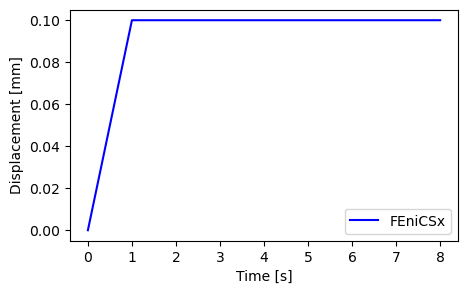

In [45]:
## Dispacement
f = plt.figure(figsize=(5,3))
plt.plot(Time,  disp_v,'b-',label='FEniCSx')

plt.xlabel('Time [s]')
plt.ylabel('Displacement [mm]')
plt.legend()
plt.show()

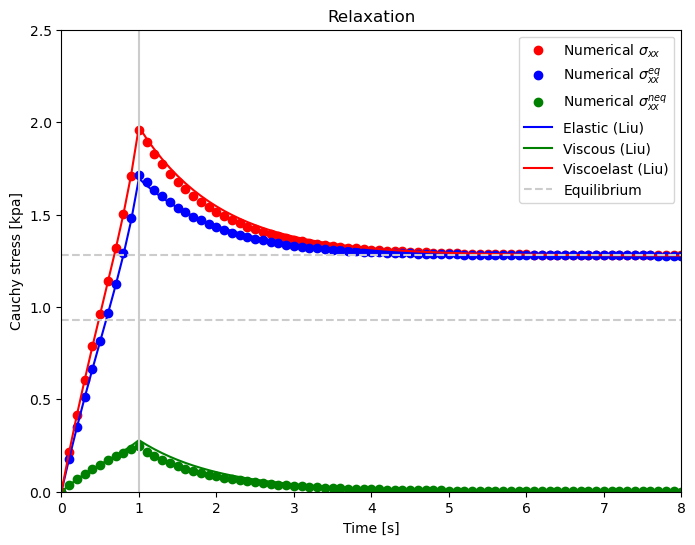

In [46]:
## Stresses
f = plt.figure(figsize=(8,6))

## FEniCSx
plt.plot(Time, SIG_v,'ro',label='Numerical $\sigma_{xx}$')
plt.plot(Time, SIGeq_v,'bo',label='Numerical $\sigma^{eq}_{xx}$')
plt.plot(Time, SIGneq_v,'go',label='Numerical $\sigma^{neq}_{xx}$')

## Liu et al.(2019)
LiuStress = np.loadtxt("data/stress.txt")

plt.plot(LiuStress[:,0], LiuStress[:,1],'b-',label='Elastic (Liu)')
plt.plot(LiuStress[:,0], LiuStress[:,2],'g-',label='Viscous (Liu)')
plt.plot(LiuStress[:,0], LiuStress[:,3],'r-',label='Viscoelast (Liu)')

plt.axhline(y=1.2808, color='0.8', linestyle='--', label = 'Equilibrium') 
plt.axhline(y=0.9293, color='0.8', linestyle='--')
plt.axvline(x = 1, color = '0.8') # Line y = 0

plt.xlabel('Time [s]')
plt.ylabel('Cauchy stress [kpa]')
plt.title('Relaxation')
plt.legend()
plt.axis([0, 8, 0, 2.5])
plt.show()

Text(0.5, 1.0, 'I4e iso')

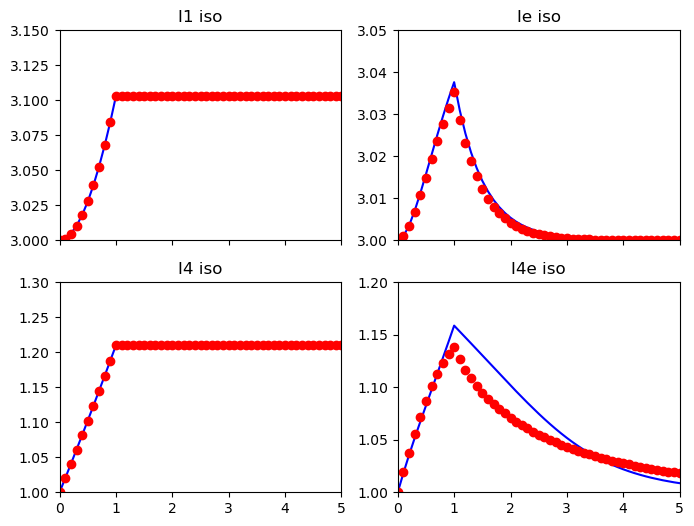

In [47]:
## Invariants

invariantsInfo = np.loadtxt("data/invariants.txt")
Time0  = invariantsInfo[:,0]
I1iso  = invariantsInfo[:,1]
Ieiso  = invariantsInfo[:,2]
I4iso  = invariantsInfo[:,3]
I4eiso = invariantsInfo[:,4]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True,figsize=(8,6))
ax1.plot(Time0, I1iso,'b-')
ax1.plot(Time, invariants[:,0],'ro')
ax1.axis([0, 5, 3, 3.15])
ax1.set_title('I1 iso')

ax2.plot(Time0, Ieiso,'b-')
ax2.plot(Time, invariants[:,1],'ro')
ax2.axis([0, 5, 3, 3.05])
ax2.set_title('Ie iso')

ax3.plot(Time0, I4iso,'b-')
ax3.plot(Time, invariants[:,2],'ro')
ax3.axis([0, 5, 1, 1.3])
ax3.set_title('I4 iso')

ax4.plot(Time0, I4eiso,'b-')
ax4.plot(Time, invariants[:,3],'ro')
ax4.axis([0, 5, 1, 1.2])
ax4.set_title('I4e iso')